In [1]:
from stabletrees import BaseLineTree, AbuTreeI, NaiveUpdate,TreeReevaluation,StabilityRegularization,BABUTree
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split,RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_poisson_deviance, mean_squared_error
from sklearn.linear_model import PoissonRegressor,LinearRegression

SEED = 0
EPSILON = 1

def S1(pred1, pred2):
    return np.std(np.log((pred2+EPSILON)/(pred1+EPSILON)))#np.mean((pred1- pred2)**2)#

def S2(pred1, pred2):
    return np.mean((pred1- pred2)**2)



In [2]:
def p1(X):
    return X[:,0]
def p2(X):
    return X[:,0]**2 + X[:,3]
def p3(X):
    return X[:,0]**2 + X[:,1]*X[:,2] + X[:,3]

cases = {"case 1": {"features": [0], "p":p1},
         "case 2": {"features": [0,3], "p":p2},
          "case 3": {"features": [0,1,2,3], "p":p3}}

np.random.seed(SEED)
n = 1000
X1 = np.random.uniform(0,4,size=(n,1))
X2 = np.random.uniform(0,4,size=(n,1))
X3 = np.round(np.random.uniform(0,1,size=(n,1)),decimals=0)
X4 = np.round(np.random.uniform(0,4,size=(n,1)),decimals=0)

X = np.hstack((X1,X2,X3,X4))

baseline [1.0298800220702495, 1.022643379408918, 1.0131811052698012, 1.0055941522734062, 1.0053549913220903, 1.0044418949726697, 1.001598838804726, 1.0004511586177354, 1.0015107491323179, 1.0014672646089695]
NU [1.040502702379713, 1.041063050067979, 1.0364810101487658, 1.0360874986342683, 1.035155973430123, 1.0341844495036459, 1.0335241091598912, 1.0333889141878705, 1.0333217230549006, 1.033102417860719]
TR [1.035740113768668, 1.0335755608856343, 1.0224724798345852, 1.019098962680892, 1.0171241676757532, 1.016597211401411, 1.0149118734827838, 1.0130263577487741, 1.0132045461353227, 1.0135469843836247]
SL [1.0364127490893953, 1.0272717019707414, 1.0201070836660622, 1.0151482091028092, 1.0114930034894294, 1.0091736321692706, 1.0072705609482955, 1.0055037834278262, 1.0042573697457189, 1.0033223145564163]
ABU [1.026321840231779, 1.0193052062597825, 1.0117841677026527, 1.005569977278332, 1.0036265133005147, 1.003279331369654, 1.001972191832731, 1.0026325437290917, 1.0018001032418815, 1.0017

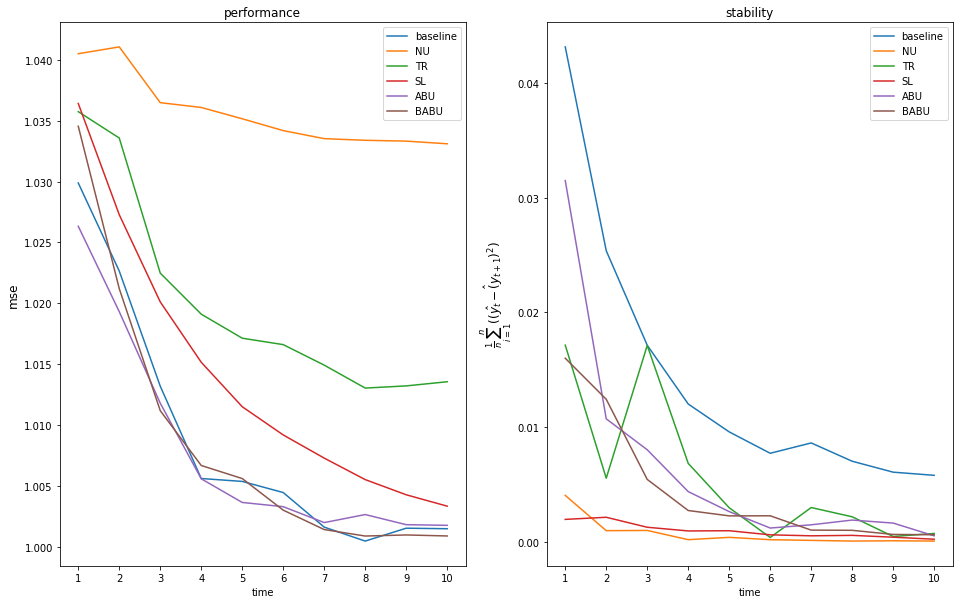

In [15]:
criterion = "mse"
models = {  
                "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                "SL":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "BABU": BABUTree(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                }
time = 10
prev_pred = {name:0 for name in models.keys()}
mse = {name:[0]*time for name in models.keys()}
stab = {name:[0]*time for name in models.keys()}
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
plt.rcParams["figure.figsize"] = (16,10)
repeat =10
for i in range(10):
    np.random.seed(i)
    x = np.sort(np.random.uniform(0,4,(1000,1)),axis=0)
    y = np.random.normal(x.ravel(),1,1000)
    np.random.seed(i+1)
    x_test = np.sort(np.random.uniform(0,4,(1000,1)),axis=0)
    y_test = np.random.normal(x_test.ravel(),1,1000)
    
    
    for name, model in models.items():
        model.fit(x,y)

        pred = model.predict(x_test)

        prev_pred[name] = pred

    
    for t in range(time): 
        x_t = np.random.uniform(0,4,(1000,1))    
        y_t = np.random.normal(x_t.ravel(),1,1000)
        x  = np.vstack((x,x_t))

        y = np.concatenate((y,y_t))

        for name, model in models.items():
            model.update(x,y)

            pred = model.predict(x_test)
            stab[name][t] += np.mean((prev_pred[name]-pred)**2)
            mse[name][t] +=np.mean((y_test-pred)**2)
            prev_pred[name] = pred

for name, model in models.items():
    print(name, [val/time for val in mse[name]])
    mse[name] = [val/repeat for val in mse[name]]
    stab[name] = [val/repeat for val in stab[name]]
    ax1.plot(np.arange(1,time+1,dtype=int),mse[name] , label = name)
    ax1.set_ylabel("mse",fontsize=12)
    ax2.plot(np.arange(1,time+1,dtype=int),stab[name] , label = name)
    ax2.set_ylabel(r"$\frac{1}{n}\sum_{i=1}^n((\hat{y_{t}} - \hat(y_{t+1})^2)$",fontsize=12)

plt.xticks(np.arange(1,time+1))
ax1.set_xlabel("time")
ax2.set_xlabel("time")
ax1.set_title("performance")
ax2.set_title("stability")
ax1.legend()
ax2.legend()

plt.show()

In [5]:
t = BaseLineTree(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
np.random.seed(0)
x = np.sort(np.random.uniform(0,4,(1000,1)),axis=0)
y = np.random.poisson(x.ravel()*2,1000)
np.random.seed(1)
x_test = np.sort(np.random.uniform(0,4,(1000,1)),axis=0)
y_test = np.random.poisson(x.ravel()*2,1000)

t.fit(x,y)
t.update(x,y)
pred = t.predict(x_test)
prev_pred = pred

np.mean((pred - y_test*np.log(pred)))

C:\Users\mb-92\AppData\Local\Temp/ipykernel_34728/196820943.py:14: RuntimeWarning: divide by zero encountered in log
  np.mean((pred - y_test*np.log(pred)))
C:\Users\mb-92\AppData\Local\Temp/ipykernel_34728/196820943.py:14: RuntimeWarning: invalid value encountered in multiply
  np.mean((pred - y_test*np.log(pred)))


nan

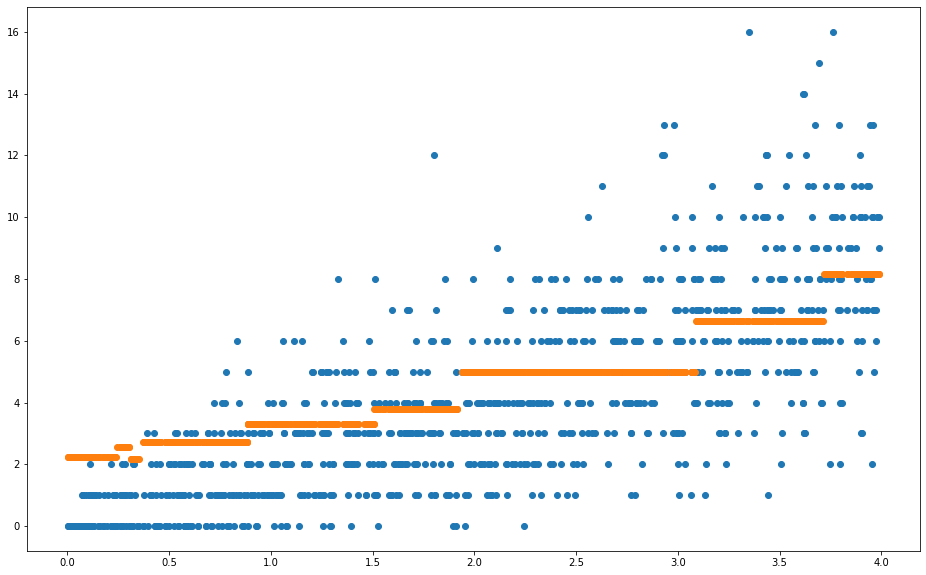

In [270]:
plt.scatter(x_test,y_test)
plt.scatter(x_test,pred)

ValueError: Mean Tweedie deviance error with power=1 can only be used on non-negative y and strictly positive y_pred.

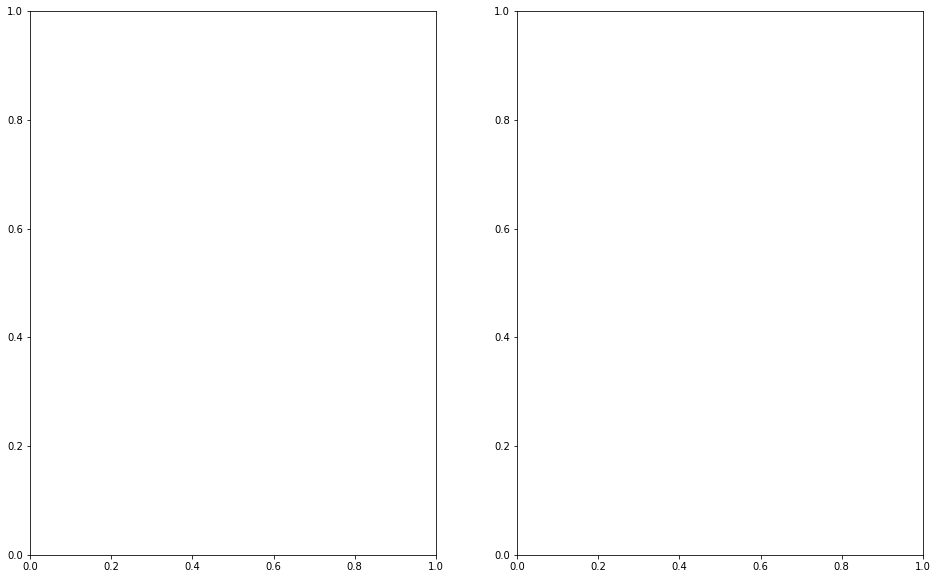

In [13]:
criterion = "poisson"
models = {  
                "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                #"TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                "SL":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "BABU": BABUTree(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                }
time = 10
prev_pred = {name:0 for name in models.keys()}
mse = {name:[0]*time for name in models.keys()}
stab = {name:[0]*time for name in models.keys()}
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
plt.rcParams["figure.figsize"] = (16,10)
repeat =20
for i in range(repeat):
    np.random.seed(i)
    x = np.sort(np.random.uniform(0,4,(1000,1)),axis=0)
    y = np.random.poisson(x.ravel(),1000)
    np.random.seed(i+1)
    x_test = np.sort(np.random.uniform(0,4,(1000,1)),axis=0)
    y_test = np.random.poisson(x_test.ravel(),1000)
 
    
    for name, model in models.items():
        model.fit(x,y)

        pred = model.predict(x_test)

        prev_pred[name] = pred

    
    for t in range(time): 
        x_t = np.random.uniform(0,4,(1000,1))    
        y_t = np.random.poisson(x_t.ravel(),1000)
        x  = np.vstack((x,x_t))

        y = np.concatenate((y,y_t))

        for name, model in models.items():
            model.update(x,y)

            pred = model.predict(x_test)
            stab[name][t] += S1(prev_pred[name] ,pred)
            mse[name][t] += mean_poisson_deviance(y_test, pred)
            prev_pred[name] = pred
baseline_mse = [val/repeat for val in mse["baseline"]]
for name, model in models.items():
    print(name, [val/repeat for val in mse[name]])
    mse[name] = [val/repeat for val in mse[name]]
    stab[name] = [val/repeat for val in stab[name]]
    ax1.plot(np.arange(1,time+1,dtype=int),mse[name] , label = name)
    ax1.set_ylabel("mse",fontsize=12)
    ax2.plot(np.arange(1,time+1,dtype=int),stab[name] , label = name)
    ax2.set_ylabel(r"$\frac{1}{n}\sum_{i=1}^n((\hat{y_{t}} - \hat(y_{t+1})^2)$",fontsize=12)

plt.xticks(np.arange(1,time+1))
ax1.set_xlabel("time")
ax2.set_xlabel("time")
ax1.set_title("performance")
ax2.set_title("stability")
ax1.legend()
ax2.legend()

plt.show()

1.1490431229962805
stab:  0.056369251029781686
mse:  1.0876749820425007
stab:  0.02819302164924354
mse:  1.081780844587152
stab:  0.007472999750789911
mse:  1.069753541101441
stab:  0.01348996922082279
mse:  1.065068117086536
stab:  0.002758612180492579
mse:  1.06306830781158


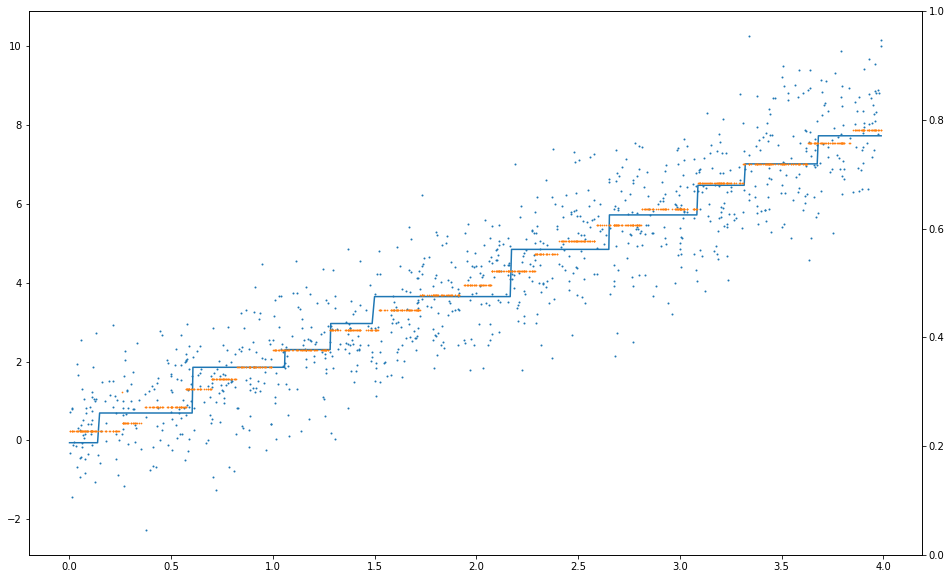

In [184]:
np.random.seed(0)
fig,ax = plt.subplots()
ax2=ax.twinx()
plt.rcParams["figure.figsize"] = (16,10)
x = np.sort(np.random.uniform(0,4,(1000,1)),axis=0)
y = np.random.normal(x.ravel()*2,1,1000)
np.random.seed(1)
x_test = np.sort(np.random.uniform(0,4,(1000,1)),axis=0)
y_test = np.random.normal(x.ravel()*2,1,1000)
t = BaseLineTree(criterion = "mse",min_samples_leaf=5, adaptive_complexity=True).fit(x,y)
#t = AbuTreeI(criterion = "mse",min_samples_leaf=5, adaptive_complexity=True).fit(x,y)
#t = BABUTree(criterion = "mse",min_samples_leaf=5, adaptive_complexity=True).fit(x,y)
#ax.scatter(x[:,0],y, zorder=0, s = 1)
ax.scatter(x_test[:,0],y_test, zorder=0, s = 1)
pred = t.predict(x_test)
ax.plot(x_test[:,0],pred, zorder=1,label = 0)
#ax2.plot(x,t.predict_infor(x)[:,1], zorder=1,label = 0,linestyle='dashed')
prev_pred = pred
print(np.mean((y_test-pred)**2))
time = 5
for i in range(time): 
    x_t = np.random.uniform(0,4,(1000,1))    
    y_t = np.random.normal(x_t.ravel()*2,1,1000)
    x  = np.vstack((x,x_t))

    y = np.concatenate((y,y_t))

    t.update(x,y)

    pred = t.predict(x_test)
    print("stab: ",np.mean((prev_pred-pred)**2))
    print("mse: ", np.mean((y_test-pred)**2))
    prev_pred = 
    #ax2.plot(x[:,0],t.predict_infor(x)[:,1], zorder=1,label=i+1, linestyle='dashed')
ax.scatter(x_test[:,0],pred, zorder=1,label=i+1,s = 0.5)


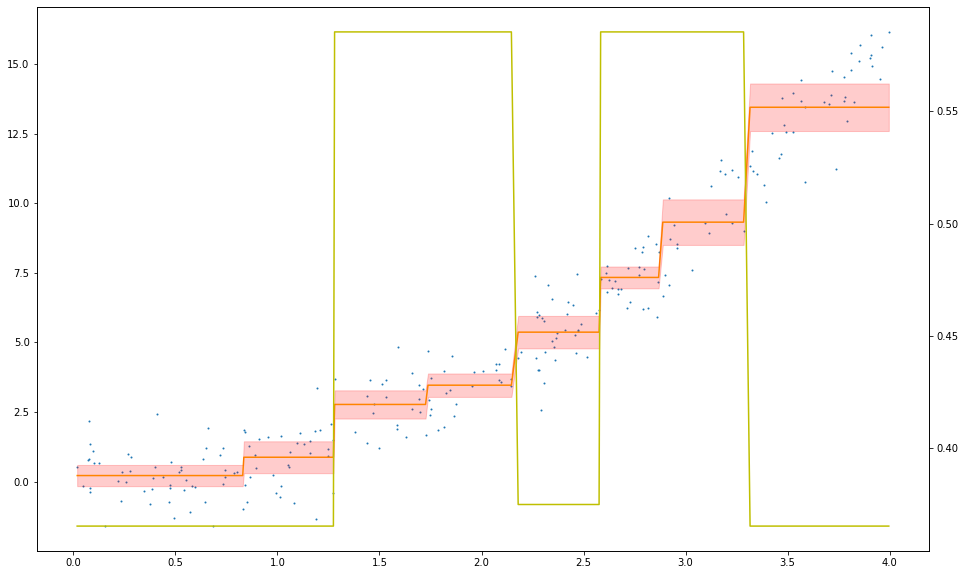

(300,) (300, 1)


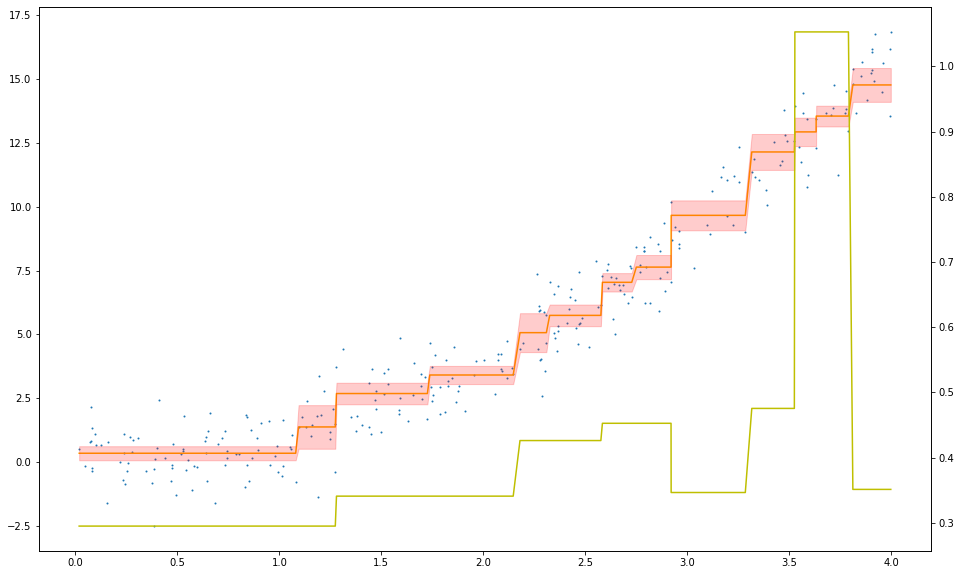

(350,) (350, 1)


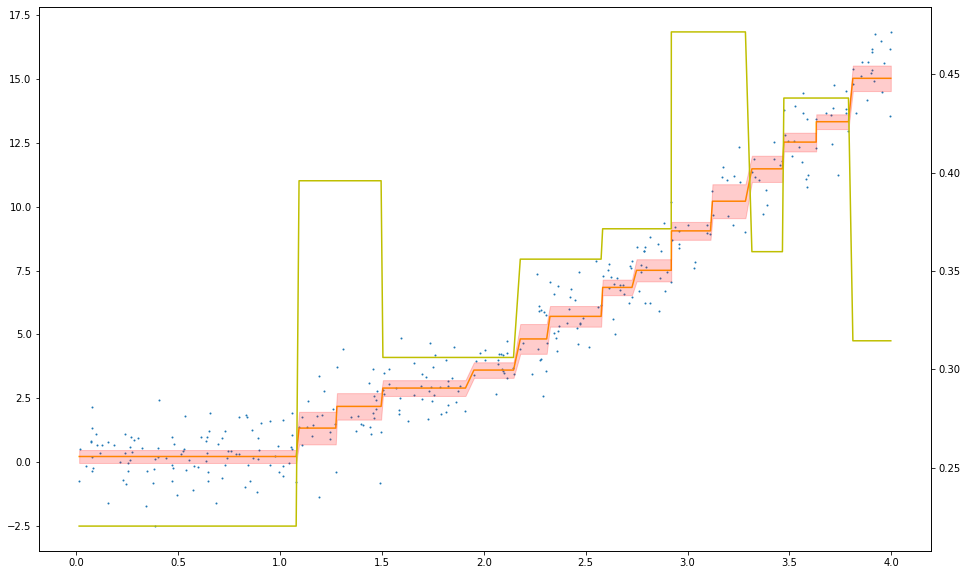

In [26]:
np.random.seed(0)
fig,ax = plt.subplots()
ax2=ax.twinx()
plt.rcParams["figure.figsize"] = (16,10)
x = np.sort(np.random.uniform(0,4,(250,1)),axis=0)
y = np.random.normal(x.ravel()**2,1,250)
t = AbuTreeI(criterion = "mse",min_samples_leaf=20, adaptive_complexity=True).fit(x,y)
pred = t.predict(x)

ax.scatter(x,y, zorder=0, s = 1)
ax.plot(x,pred,c="orange", zorder=1)
ax.fill_between(x.ravel(), pred -np.sqrt(t.predict_uncertainty(x))*1.96, y2=pred +np.sqrt(t.predict_uncertainty(x))*1.96 , alpha=0.2, label='95% CI', color = "red", interpolate=True)

ax2.plot(x,t.predict_infor(x)[:,1],c="y", zorder=1)
plt.show()

fig,ax = plt.subplots()
ax2=ax.twinx()
x2 = np.sort(np.random.uniform(0,4,(50,1)),axis=0)
y2 = np.random.normal(x2.ravel()**2,1,50)
x = np.vstack((x,x2))
ind = np.argsort(x, axis=0).ravel()
y = np.concatenate((y,y2), axis= 0)
x = x[ind]
y = y[ind]
print(y.shape,x.shape )
t.update(x,y)
ax.scatter(x,y, zorder=0, s = 1)
pred = t.predict(x)
ax.plot(x,pred,c="orange", zorder=1)
ax.fill_between(x.ravel(), pred -np.sqrt(t.predict_uncertainty(x))*1.96, y2=pred +np.sqrt(t.predict_uncertainty(x))*1.96 , alpha=0.2, label='95% CI', color = "red", interpolate=True)
ax2.plot(x,t.predict_infor(x)[:,1],c="y", zorder=1)
plt.show()

fig,ax = plt.subplots()
ax2=ax.twinx()
x2 = np.sort(np.random.uniform(0,4,(50,1)),axis=0)
y2 = np.random.normal(x2.ravel()**2,1,50)
x = np.vstack((x,x2))
ind = np.argsort(x, axis=0).ravel()
y = np.concatenate((y,y2), axis= 0)
x = x[ind]
y = y[ind]
print(y.shape,x.shape )
t.update(x,y)
ax.scatter(x,y, zorder=0, s = 1)
pred = t.predict(x)
ax.plot(x,pred,c="orange", zorder=1)
ax.fill_between(x.ravel(), pred -np.sqrt(t.predict_uncertainty(x))*1.96, y2=pred +np.sqrt(t.predict_uncertainty(x))*1.96 , alpha=0.2, label='95% CI', color = "red", interpolate=True)
ax2.plot(x,t.predict_infor(x)[:,1],c="y", zorder=1)
plt.show()


case 1
baseline
test - mse: 1.041 (1.00), stability: 0.081 (1.00)
NU
test - mse: 1.058 (1.02), stability: 0.011 (0.13)
TR
test - mse: 1.056 (1.01), stability: 0.040 (0.49)
SL
test - mse: 1.045 (1.00), stability: 0.018 (0.22)
ABU
test - mse: 1.038 (1.00), stability: 0.068 (0.84)
BABU
test - mse: 1.051 (1.01), stability: 0.025 (0.31)
 
case 2
baseline
test - mse: 1.444 (1.00), stability: 0.605 (1.00)
NU
test - mse: 1.579 (1.09), stability: 0.050 (0.08)
TR
test - mse: 1.505 (1.04), stability: 0.335 (0.55)
SL
test - mse: 1.396 (0.97), stability: 0.185 (0.31)
ABU
test - mse: 1.407 (0.97), stability: 0.442 (0.73)
BABU
test - mse: 1.416 (0.98), stability: 0.188 (0.31)
 
case 3
baseline
test - mse: 2.248 (1.00), stability: 1.940 (1.00)
NU
test - mse: 2.833 (1.26), stability: 0.102 (0.05)
TR
test - mse: 2.446 (1.09), stability: 1.256 (0.65)
SL
test - mse: 2.278 (1.01), stability: 0.528 (0.27)
ABU
test - mse: 2.254 (1.00), stability: 1.469 (0.76)
BABU
test - mse: 2.316 (1.03), stability: 0.597 (

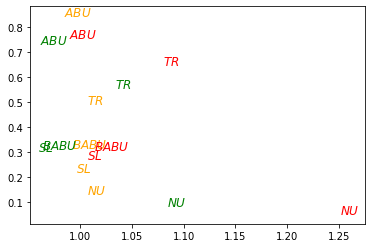

In [7]:
n = 1000
np.random.seed(SEED)
X1 = np.random.uniform(0,4,size=(n,1))
X2 = np.random.uniform(0,4,size=(n,1))
X3 = np.round(np.random.uniform(0,1,size=(n,1)),decimals=0)
X4 = np.round(np.random.uniform(0,4,size=(n,1)),decimals=0)

X = np.hstack((X1,X2,X3,X4))
colors = {"case 1":"orange", "case 2": "g", "case 3":"r"}
#markers = {"baseline":"o", "NU": "v", "TR":"^", "TR":"s", "SL":"D","ABU":"+", "BABU": "*" }
markers = {"baseline":"$B$", "NU": "$NU$", "TR":"$TR$", "TR":"$TR$", "SL":"$SL$","ABU":"$ABU$", "BABU": "$BABU$" }

fig, ax = plt.subplots()
for case, info in cases.items():
        np.random.seed(SEED)
        features = info["features"]
        p = info["p"]
        x = X[:,features]
        y = np.random.normal(loc = p(X), scale=1,size=n)
        kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)
        criterion = "mse"
        models = {  
                        "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                        #"sklearn": DecisionTreeRegressor(criterion = criterion,min_samples_leaf=5, max_depth=10),
                        #"glm": LinearRegression(),
                        "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                        "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                        "SL":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                        "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                        "BABU": BABUTree(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                        }
        preds  = {k :np.zeros((200,100)) for k in models.keys()}
        stability = {k :[] for k in models.keys()}
        performance = {k :[] for k in models.keys()}
        for i,(train_index, test_index) in enumerate(kf.split(x)):

                X_12, y_12 = x[train_index],y[train_index]
                X_test,y_test = x[test_index],y[test_index]
                X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
                for name, model in models.items():
                        model.fit(X1,y1)
                        pred1 = model.predict(X_test)
                        if name =="glm" or name =="sklearn":
                                model.fit(X_12,y_12)
                        else:
                                model.update(X_12,y_12)
                        pred2 = model.predict(X_test)
                        preds[name][:,i] = (pred1-pred2)**2
                        stability[name].append( S2(pred1,pred2))
                        performance[name].append(mean_squared_error(y_test, pred2))
        print(case)
        for name in models.keys():
                print("="*80)
                print(f"{name}")

                mse_scale = np.mean(performance["baseline"]); S_scale = np.mean(stability["baseline"]);

                print(f"test - mse: {np.mean(performance[name]):.3f} ({np.mean(performance[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S_scale:.2f})")
                print("="*80)
                if name != "baseline":
                        plt.text(x = np.mean(performance[name])/mse_scale, y = np.mean(stability[name])/S_scale, s = markers[name], fontsize=12,ha='center',c =colors[case]) 
                        plt.scatter(np.mean(performance[name])/mse_scale, np.mean(stability[name])/S_scale, c = colors[case], marker="none",s = 700)
        print(" ") 
# from matplotlib.lines import Line2D
# legend_elements = [Line2D([0], [0], marker='s', color='w', label=k,
#                           markerfacecolor=v, markersize=14) for k,v in colors.items()  ]
# legend_elements = [Line2D([0], [0], color='b', lw=1, label='baseline', linestyle = "--")] +legend_elements
# plt.axvline(x=1, linestyle = "--")
# plt.axhline(y=1, linestyle = "--")
# plt.xlabel("mse",fontsize=14)
# plt.ylabel(r'$\left(f_1(x_i)-f_2(x_i)\right)^2$',fontsize=14)
# plt.ylim((0,1.25))
# #plt.xlim((0,2))
# ax.legend(handles=legend_elements)
# plt.show()

    
    

In [3]:
n = 1000
for case, info in cases.items():
        np.random.seed(SEED)
        features = info["features"]
        p = info["p"]
        x = X[:,features]
        y = np.random.poisson(lam = p(X),size=n)
        kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)
        criterion = "poisson"
        models = {  
                        "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                        "sklearn": DecisionTreeRegressor(criterion = criterion,min_samples_leaf=5, max_depth=10),
                        "glm": PoissonRegressor(alpha=0.01),
                        "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                        "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                        "SR":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                        "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                        "iABU": BABUTree(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                        }
        preds  = {k :np.zeros((200,100)) for k in models.keys()}
        stability = {k :[] for k in models.keys()}
        performance = {k :[] for k in models.keys()}
        for i,(train_index, test_index) in enumerate(kf.split(x)):

                X_12, y_12 = x[train_index],y[train_index]
                X_test,y_test = x[test_index],y[test_index]
                X_test = np.sort(X_test)
                X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
                for name, model in models.items():
                        model.fit(X1,y1)
                        pred1 = model.predict(X_test)
                        if name =="glm" or name =="sklearn":
                                model.fit(X_12,y_12)
                        else:
                                model.update(X_12,y_12)
                        pred2 = model.predict(X_test)
                        preds[name][:,i] = (pred1-pred2)**2
                        stability[name].append( S1(pred1,pred2))
                        performance[name].append(mean_poisson_deviance(y_test+0.001, pred2+0.001))
        print(case)
        for name in models.keys():
                print("="*80)
                print(f"{name}")

                mse_scale = np.mean(performance["baseline"]); S_scale = np.mean(stability["baseline"]);

                print(f"test - mse: {np.mean(performance[name]):.3f} ({np.mean(performance[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S_scale:.2f})")
                print("="*80)
        print(" ")

    
    

case 1
baseline
test - mse: 1.282 (1.00), stability: 0.084 (1.00)
sklearn
test - mse: 1.461 (1.14), stability: 0.196 (2.33)
glm
test - mse: 1.083 (0.84), stability: 0.011 (0.13)
NU
test - mse: 1.287 (1.00), stability: 0.022 (0.26)
TR
test - mse: 1.282 (1.00), stability: 0.042 (0.50)
SR
test - mse: 1.270 (0.99), stability: 0.023 (0.27)
ABU
test - mse: 1.284 (1.00), stability: 0.075 (0.89)
iABU
test - mse: 1.264 (0.99), stability: 0.052 (0.62)
 
case 2
baseline
test - mse: 3.018 (1.00), stability: 0.081 (1.00)
sklearn
test - mse: 5.198 (1.72), stability: 0.186 (2.29)
glm
test - mse: 4.294 (1.42), stability: 0.012 (0.15)
NU
test - mse: 3.064 (1.02), stability: 0.024 (0.29)
TR
test - mse: 3.012 (1.00), stability: 0.061 (0.75)
SR
test - mse: 3.095 (1.03), stability: 0.047 (0.58)
ABU
test - mse: 3.015 (1.00), stability: 0.078 (0.96)
iABU
test - mse: 3.031 (1.00), stability: 0.072 (0.89)
 
case 3
baseline
test - mse: 4.203 (1.00), stability: 0.062 (1.00)
sklearn
test - mse: 4.844 (1.15), stab

# Poisson
# $\lambda = X_1\sim \mathcal{U}(0,4)$

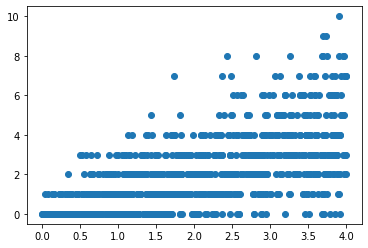

1.983686137487131


In [5]:
n = 1000
np.random.seed(SEED)
X = np.random.uniform(low=0,high=4,size=(n,1))
y = np.random.poisson(lam=X[:,0],size=n)
plt.scatter(X,y)
plt.show()
print(np.mean(X[:,0]))

In [6]:
kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)
criterion = "poisson"
models = {  
                "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, max_depth=10),
                "sklearn": DecisionTreeRegressor(criterion = criterion,min_samples_leaf=5, max_depth=10),
                #"glm": PoissonRegressor(alpha=0.01),
                #"NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,),
                #"TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                "SR":StabilityRegularization(criterion = criterion,min_samples_leaf=5, max_depth=10,lmbda=0.75),
                "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5, max_depth=10),
                "iABU": BABUTree(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                
                #  "baseline": BaseLineTree(**params), 
                # "NU": StableTree0(**params),
                #  "TR":TreeReevaluation(criterion = criterion,**params, delta=0.1)
                #  #"SR":StableTree2(**params,lmda=0.5),
                #  "ABU":AbuTreeI(**params)
                }

preds  = {k :np.zeros((200,100)) for k in models.keys()}
stability = {k :[] for k in models.keys()}
performance = {k :[] for k in models.keys()}
for i,(train_index, test_index) in enumerate(kf.split(X)):

        X_12, y_12 = X[train_index],y[train_index]
        X_test,y_test = X[test_index],y[test_index]
        X_test = np.sort(X_test)
        X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
        for name, model in models.items():
                model.fit(X1,y1)
                pred1 = model.predict(X_test)
                if name =="glm" or name =="sklearn":
                        model.fit(X_12,y_12)
                else:
                        model.update(X_12,y_12)
                pred2 = model.predict(X_test)
                preds[name][:,i] = (pred1-pred2)**2
                stability[name].append( S1(pred1,pred2))
                performance[name] = mean_poisson_deviance(y_test+0.001, pred2+0.001,)

for name in models.keys():
        print("="*80)
        print(f"{name}")

        mse_scale = np.mean(performance["baseline"]); S_scale = np.mean(stability["baseline"]);

        print(f"test - mse: {np.mean(performance[name]):.3f} ({np.mean(performance[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S_scale:.2f})")
        print("="*80)


baseline
test - mse: 1.407 (1.00), stability: 0.192 (1.00)
sklearn
test - mse: 1.344 (0.95), stability: 0.223 (1.16)
SR
test - mse: 1.299 (0.92), stability: 0.071 (0.37)
ABU
test - mse: 1.351 (0.96), stability: 0.110 (0.57)
iABU
test - mse: 1.250 (0.89), stability: 0.006 (0.03)


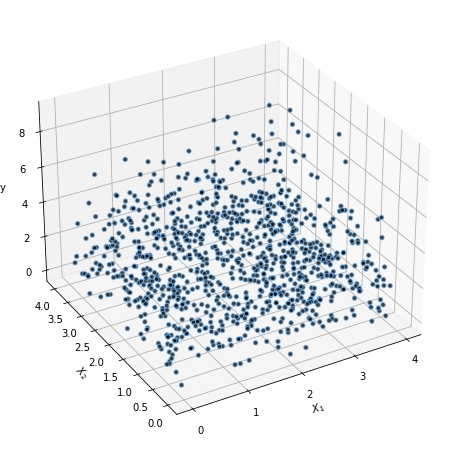

In [7]:
n = 1000
np.random.seed(SEED)
def p2(X):
    return X.sum(axis=1)/10 + 0.1*X[:,1]*np.log(X[:,2]) +0.1*X[:,3]*(4-X[:,4]) 
X = np.random.uniform(low=0,high=4,size=(n,10))
y = np.random.poisson(lam=p2(X),size=n)


fig = plt.figure(figsize=(8, 8))
x = X[:, 0]
z = X[:, 1]
x_pred = np.linspace(0, 4, 50)   # range of porosity values
z_pred = np.linspace(0, 4, 50)  # range of brittleness values
xx_pred, zz_pred = np.meshgrid(x_pred, z_pred)
model_viz = np.array([xx_pred.flatten(), zz_pred.flatten()]).T


#plt.style.use('default')

tree = BaseLineTree(criterion="mse",adaptive_complexity=True,max_depth=3).fit(X,y)
ax1 = fig.add_subplot(111, projection='3d')




samples = 10
predicted = tree.predict(model_viz)#tree.predict(model_viz)
axes = [ax1]

for ax in axes:
    ax.scatter(x, z, y, facecolor=(0,0,0,0), s=20, alpha=0.75,edgecolor='#70b3f0')
    ax.set_xlabel('$X_1$', fontsize=10)
    plt.xticks(np.arange(0, 4.1, step=1))
    ax.set_ylabel('$X_2$', fontsize=10)
    ax.set_zlabel('y', fontsize=10)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')



ax1.view_init(elev=30, azim=-120)


#fig.tight_layout()
plt.show()

In [8]:
kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)
criterion = "poisson"
models = {  
                "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "glm": PoissonRegressor(alpha=0.01),
                "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,),
                "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                "SR":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True),
                "iABU": BABUTree(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                
                #  "baseline": BaseLineTree(**params), 
                # "NU": StableTree0(**params),
                #  "TR":TreeReevaluation(criterion = criterion,**params, delta=0.1)
                #  #"SR":StableTree2(**params,lmda=0.5),
                #  "ABU":AbuTreeI(**params)
                }

preds  = {k :np.zeros((200,100)) for k in models.keys()}
stability = {k :[] for k in models.keys()}
performance = {k :[] for k in models.keys()}
for i,(train_index, test_index) in enumerate(kf.split(X)):

        X_12, y_12 = X[train_index],y[train_index]
        X_test,y_test = X[test_index],y[test_index]
        X_test = np.sort(X_test)
        X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
        for name, model in models.items():
                model.fit(X1,y1)
                pred1 = model.predict(X_test)
                if name =="glm":
                        model.fit(X_12,y_12)
                else:
                        model.update(X_12,y_12)
                pred2 = model.predict(X_test)
                preds[name][:,i] = (pred1-pred2)**2
                stability[name].append( S1(pred1,pred2))
                performance[name] = mean_squared_error(y_test, pred2)

for name in models.keys():
        print("="*80)
        print(f"{name}")

        mse_scale = np.mean(performance["baseline"]); S_scale = np.mean(stability["baseline"]);

        print(f"test - mse: {np.mean(performance[name]):.3f} ({np.mean(performance[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S_scale:.2f})")
        print("="*80)


baseline
test - mse: 2.231 (1.00), stability: 0.088 (1.00)
glm
test - mse: 2.136 (0.96), stability: 0.020 (0.23)
NU
test - mse: 2.240 (1.00), stability: 0.010 (0.11)
TR
test - mse: 2.240 (1.00), stability: 0.010 (0.11)
SR
test - mse: 2.235 (1.00), stability: 0.021 (0.23)
ABU
test - mse: 2.248 (1.01), stability: 0.031 (0.35)
iABU
test - mse: 2.258 (1.01), stability: 0.006 (0.07)


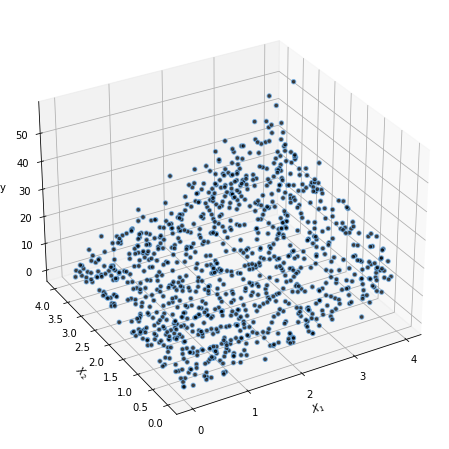

In [9]:
n = 1000
np.random.seed(SEED)
X = np.random.uniform(low=0,high=4,size=(n,2))
y = np.random.poisson(lam=X[:,0]**2+X[:,0]*X[:,1]+X[:,1],size=n)


fig = plt.figure(figsize=(8, 8))
x = X[:, 0]
z = X[:, 1]
x_pred = np.linspace(0, 4, 50)   # range of porosity values
z_pred = np.linspace(0, 4, 50)  # range of brittleness values
xx_pred, zz_pred = np.meshgrid(x_pred, z_pred)
model_viz = np.array([xx_pred.flatten(), zz_pred.flatten()]).T


#plt.style.use('default')

tree = BaseLineTree(criterion="mse",adaptive_complexity=True,max_depth=3).fit(X,y)
ax1 = fig.add_subplot(111, projection='3d')




samples = 10
predicted = tree.predict(model_viz)#tree.predict(model_viz)
axes = [ax1]

for ax in axes:
    ax.scatter(x, z, y, facecolor=(0,0,0,0), s=20, alpha=0.75,edgecolor='#70b3f0')
    ax.set_xlabel('$X_1$', fontsize=10)
    plt.xticks(np.arange(0, 4.1, step=1))
    ax.set_ylabel('$X_2$', fontsize=10)
    ax.set_zlabel('y', fontsize=10)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')



ax1.view_init(elev=30, azim=-120)


#fig.tight_layout()
plt.show()

In [10]:
kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)
criterion = "poisson"
models = {  
                "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "glm": PoissonRegressor(alpha=0.01),
                "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,),
                "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                "SR":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True),
                "iABU": BABUTree(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                
                #  "baseline": BaseLineTree(**params), 
                # "NU": StableTree0(**params),
                #  "TR":TreeReevaluation(criterion = criterion,**params, delta=0.1)
                #  #"SR":StableTree2(**params,lmda=0.5),
                #  "ABU":AbuTreeI(**params)
                }

preds  = {k :np.zeros((200,100)) for k in models.keys()}
stability = {k :[] for k in models.keys()}
performance = {k :[] for k in models.keys()}
for i,(train_index, test_index) in enumerate(kf.split(X)):

        X_12, y_12 = X[train_index],y[train_index]
        X_test,y_test = X[test_index],y[test_index]
        X_test = np.sort(X_test)
        X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
        for name, model in models.items():
                model.fit(X1,y1)
                pred1 = model.predict(X_test)
                if name =="glm":
                        model.fit(X_12,y_12)
                else:
                        model.update(X_12,y_12)
                pred2 = model.predict(X_test)
                preds[name][:,i] = (pred1-pred2)**2
                stability[name].append( S1(pred1,pred2))
                performance[name] = mean_squared_error(y_test, pred2)

for name in models.keys():
        print("="*80)
        print(f"{name}")

        mse_scale = np.mean(performance["baseline"]); S_scale = np.mean(stability["baseline"]);

        print(f"test - mse: {np.mean(performance[name]):.3f} ({np.mean(performance[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S_scale:.2f})")
        print("="*80)


baseline
test - mse: 30.216 (1.00), stability: 0.100 (1.00)
glm
test - mse: 29.765 (0.99), stability: 0.009 (0.09)
NU
test - mse: 30.088 (1.00), stability: 0.027 (0.27)
TR
test - mse: 30.088 (1.00), stability: 0.027 (0.27)
SR
test - mse: 29.903 (0.99), stability: 0.074 (0.74)
ABU
test - mse: 29.585 (0.98), stability: 0.046 (0.46)
iABU
test - mse: 27.718 (0.92), stability: 0.039 (0.39)


2.5805153207389324
0.0218100122588019
0.2607268766249365
0.2607268766249365
1.497334358216053
0.6279025807331597


ValueError: num must be 1 <= num <= 6, not 7

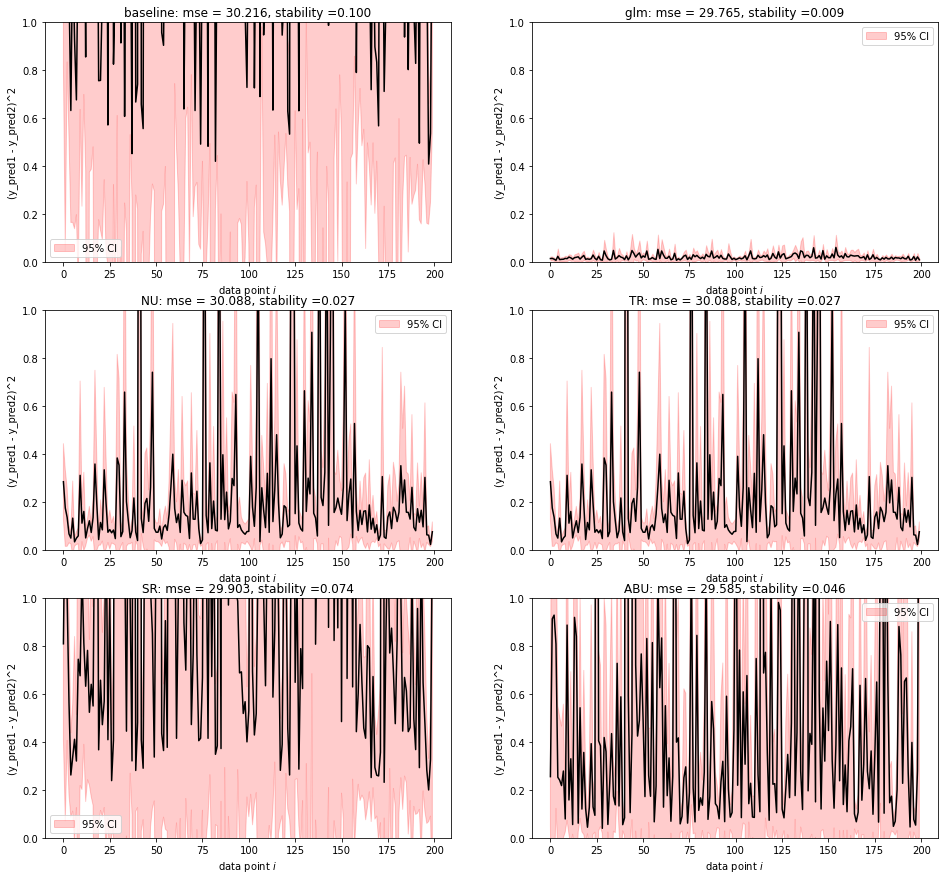

In [11]:
fig = plt.figure(figsize=(16, 15))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(3,2,i+1)

    y_mean = np.mean(preds[name],axis=1)
    y_std = np.std(preds[name],axis=1)
    ci = 1.96 * y_std / np.sqrt(preds[name].shape[1])
    plt.plot(np.arange(0,preds[name].shape[0],1), y_mean, color = "black")
    plt.fill_between(np.arange(0,preds[name].shape[0],1), y_mean-ci, y_mean+ci, alpha=0.2, label='95% CI', color = "red", interpolate=True)
    plt.ylim((0,1))
    # Set the plot title and axis labels
    plt.title('Line plot with error bars')
    plt.xlabel('data point $i$')
    plt.ylabel('(y_pred1 - y_pred2)^2')
    plt.title(f'{name}: mse = {np.mean(performance[name]):.3f}, stability ={np.mean(stability[name]):.3f}')
    plt.legend()
    print(np.mean(preds[name]))
    # Show the plot
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
n = 1000
np.random.seed(SEED)
X = np.random.uniform(low=0,high=4,size=(n,2))
y = np.random.normal(loc=X[:,0]+X[:,1],scale=1,size=n)

(50, 50) (50, 50) (50, 50)


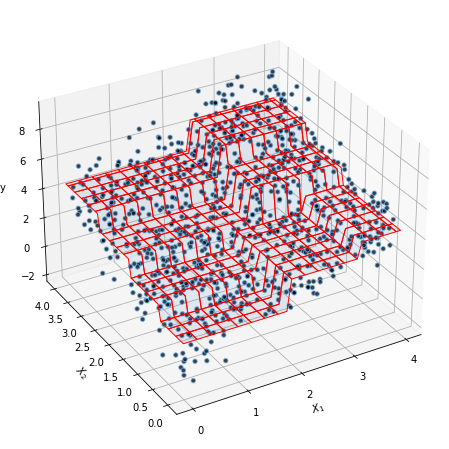

In [ ]:
# create a meshgrid of points
fig = plt.figure(figsize=(8, 8))
x = X[:, 0]
z = X[:, 1]
x_pred = np.linspace(0, 4, 50)   # range of porosity values
z_pred = np.linspace(0, 4, 50)  # range of brittleness values
xx_pred, zz_pred = np.meshgrid(x_pred, z_pred)
model_viz = np.array([xx_pred.flatten(), zz_pred.flatten()]).T


#plt.style.use('default')

tree = BaseLineTree(criterion="mse",adaptive_complexity=True,max_depth=3).fit(X,y)
ax1 = fig.add_subplot(111, projection='3d')




samples = 10
predicted = tree.predict(model_viz)#tree.predict(model_viz)
axes = [ax1]
print(xx_pred.shape,zz_pred.shape, predicted.reshape(50,50).shape)
for ax in axes:
    ax.scatter(x, z, y, facecolor=(0,0,0,0), s=20, alpha=0.75,edgecolor='#70b3f0')
    ax.plot_surface(xx_pred, zz_pred, predicted.reshape(50,50), edgecolor='r',alpha=0.1, rcount=20,ccount=20)
    ax.set_xlabel('$X_1$', fontsize=10)
    plt.xticks(np.arange(0, 4.1, step=1))
    ax.set_ylabel('$X_2$', fontsize=10)
    ax.set_zlabel('y', fontsize=10)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')



ax1.view_init(elev=30, azim=-120)


#fig.tight_layout()
plt.show()

Text(0, 0.5, '$X_2$')

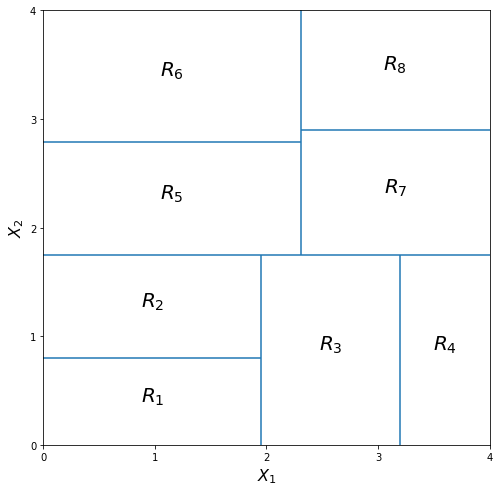

In [ ]:
index = 1
def _draw_line(node,x_min = 0,x_max=4,y_min=0,y_max=4):
    global index
    x_min_next = x_min
    x_max_next = x_max
    y_min_next = y_min
    y_max_next = y_max
    if node.is_leaf():
        plt.text((x_max+x_min)/2, (y_max+y_min)/2,f"$R_{index}$", fontsize=20,ha='center') 
        index+=1
        return
    dim = node.get_split_feature()
    val = node.get_split_value()
    if dim==0:
        plt.vlines(x = val,ymin=y_min, ymax= y_max)
        x_min_next = val
        x_max_next = val
    else:
        plt.hlines(y = val,xmin=x_min, xmax=x_max)
        y_min_next = val
        y_max_next = val
    
    _draw_line(node.get_left_node(),x_min,x_max_next,y_min ,y_max_next )
    _draw_line(node.get_right_node(),x_min_next,x_max,y_min_next ,y_max)


node = tree.root
fig = plt.figure(figsize=(8, 8))
_draw_line(node)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xticks(np.arange(0, 4.1, step=1))
plt.yticks(np.arange(0, 4.1, step=1))
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)

In [ ]:
kf = RepeatedKFold(n_splits= 5,n_repeats=20, random_state=SEED)
criterion = "mse"
models = {  
                "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                #"NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,),
                #"TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                #"SR":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                #"ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True),
                #"iABU": BABUTree(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                
                #  "baseline": BaseLineTree(**params), 
                # "NU": StableTree0(**params),
                #  "TR":TreeReevaluation(criterion = criterion,**params, delta=0.1)
                #  #"SR":StableTree2(**params,lmda=0.5),
                #  "ABU":AbuTreeI(**params)
                }

preds  = {k :np.zeros((200,100)) for k in models.keys()}
stability = {k :[] for k in models.keys()}
performance = {k :[] for k in models.keys()}
for i,(train_index, test_index) in enumerate(kf.split(X)):
        X_12, y_12 = X[train_index],y[train_index]
        X_test,y_test = X[test_index],y[test_index]
        X_test = np.sort(X_test)
        X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
        for name, model in models.items():
                model.fit(X1,y1)
                pred1 = model.predict(X_test)
                model.update(X_12,y_12)
                pred2 = model.predict(X_test)
                preds[name][:,i] = (pred1-pred2)**2
                stability[name].append( np.mean((pred1-pred2)**2))
                performance[name] = mean_squared_error(y_test, pred2)

0.02651994849831472


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

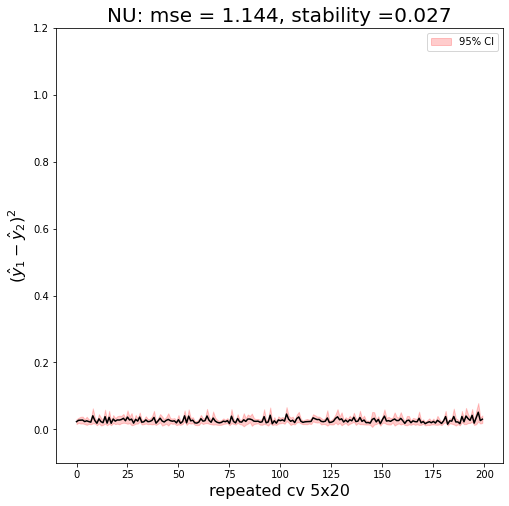

0.18706128670054784


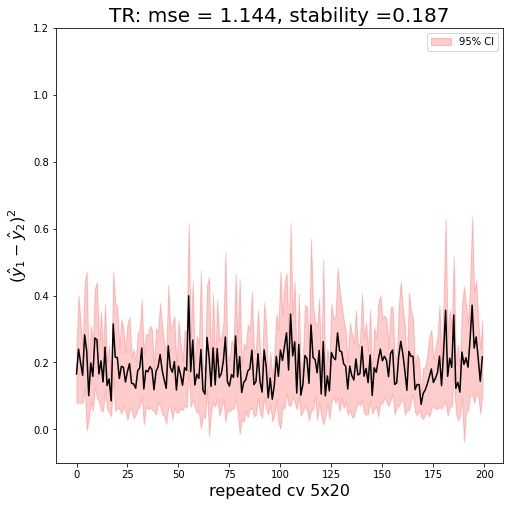

0.02797681995549012


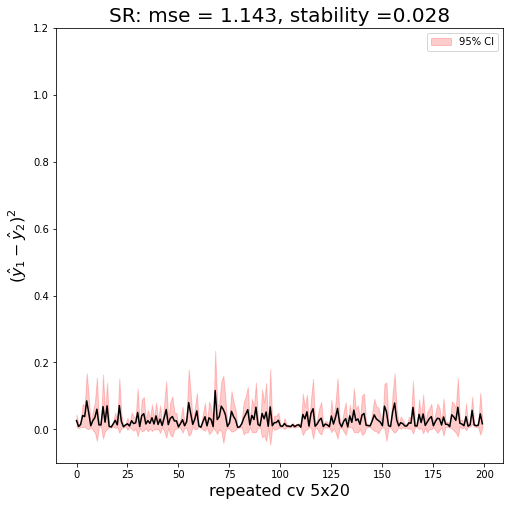

0.27375891181060885


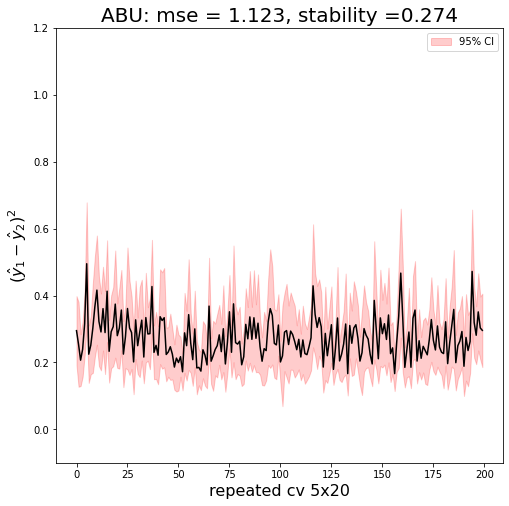

0.12015270635439135


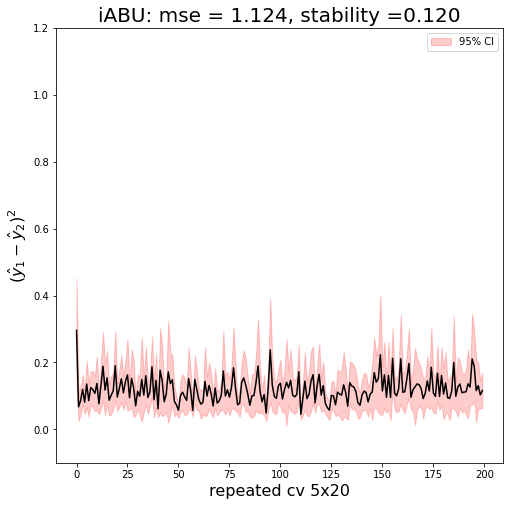

In [ ]:
fig = plt.figure(figsize=(8, 8))
y_mean_base = np.mean(preds["baseline"],axis=1)
for i, (name, model) in enumerate(models.items()):
    fig = plt.figure(figsize=(8, 8))
    if i ==0:
        continue
    #plt.subplot(3,2,i)

    y_mean = np.mean(preds[name],axis=1)
    y_std = np.std(preds[name],axis=1)
    ci = 1.96 * y_std / np.sqrt(preds[name].shape[1])
    #plt.plot(np.arange(0,preds["baseline"].shape[0],1), y_mean_base, color = "blue")
    plt.plot(np.arange(0,preds[name].shape[0],1), y_mean, color = "black")
    plt.fill_between(np.arange(0,preds[name].shape[0],1), y_mean-ci, y_mean+ci, alpha=0.2, label='95% CI', color = "red", interpolate=True)
    plt.ylim((-0.1,1.2))
    # Set the plot title and axis labels
    plt.title('Line plot with error bars')
    plt.xlabel('repeated cv 5x20',fontsize=16)
    plt.ylabel('$(\hat{y}_1 - \hat{y}_2)^2$',fontsize=16)
    plt.title(f'{name}: mse = {np.mean(performance[name]):.3f}, stability ={np.mean(stability[name]):.3f}',fontsize=20)
    plt.legend()
    print(np.mean(np.mean(preds[name],axis=0)))
    plt.show()
    # Show the plot


0.3284189093221037


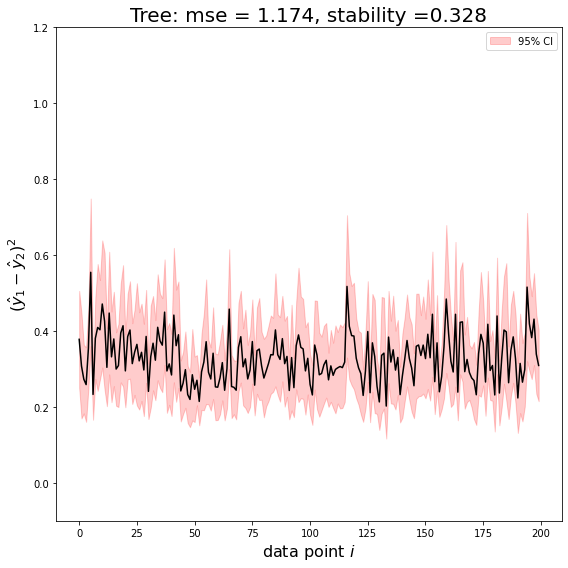

In [ ]:
fig = plt.figure(figsize=(8, 8))
name = "baseline"
model  = models[name]


y_mean = np.mean(preds[name],axis=1)
y_std = np.std(preds[name],axis=1)
ci = 1.96 * y_std / np.sqrt(preds[name].shape[1])
plt.plot(np.arange(0,preds[name].shape[0],1), y_mean, color = "black")
plt.fill_between(np.arange(0,preds[name].shape[0],1), y_mean-ci, y_mean+ci, alpha=0.2, label='95% CI', color = "red", interpolate=True)
plt.ylim((-0.1,1.2))
# Set the plot title and axis labels
plt.xlabel('data point $i$',fontsize=16)
plt.ylabel('$(\hat{y}_1 - \hat{y}_2)^2$',fontsize=16)
plt.title(f'Tree: mse = {np.mean(performance[name]):.3f}, stability ={np.mean(stability[name]):.3f}',fontsize=20)
plt.legend()
print(np.mean(np.mean(preds[name],axis=0)))
    
    # Show the plot
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'get_facecolor'

In [ ]:
SEED = 0
EPSILON = 2
kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)


def S1(pred1, pred2):
    return np.std(np.log((pred2+EPSILON)/(pred1+EPSILON)))#np.mean((pred1- pred2)**2)#

def S2(pred1, pred2):
    return np.mean((pred1- pred2)**2)

#if ds == "College":
#    y = np.log(y)

# initial model 
n = 1000
np.random.seed(SEED)
X = np.random.uniform(low=0,high=4,size=(n,2))
y = np.random.normal(loc=X[:,0]+X[:,1],scale=1,size=n)


stability = {name:[] for name in models.keys()}
standard_stability = {name:[] for name in models.keys()}
mse = {name:[] for name in models.keys()}
train_stability = {name:[] for name in models.keys()}
train_standard_stability = {name:[] for name in models.keys()}
train_mse = {name:[] for name in models.keys()}
orig_stability = {name:[] for name in models.keys()}
orig_standard_stability = {name:[] for name in models.keys()}

stability_all = {name:[] for name in models.keys()}
standard_stability_all= {name:[] for name in models.keys()}
mse_all= {name:[] for name in models.keys()}
orig_mse = {name:[] for name in models.keys()}
models = {  
            "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
            #"GLM": LinearRegression(),
            #"sklearn": SklearnTree(criterion = criterion,**params),
            "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,),
            "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.5),
            "SL":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
            "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True),
            "BABU": BABUTree(criterion = criterion, adaptive_complexity=True)
            }
for train_index, test_index in kf.split(X):
    X_12, y_12 = X[train_index],y[train_index]
    X_test,y_test = X[test_index],y[test_index]
    X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
    # initial model 
    criterion = "mse"
    models = {  
            "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
            #"GLM": LinearRegression(),
            #"sklearn": SklearnTree(criterion = criterion,**params),
            "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,),
            "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.5),
            "SL":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
            "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True),
            "BABU": BABUTree(criterion = criterion, adaptive_complexity=True)
            }
    for name, model in models.items():
        model.fit(X1,y1)
        pred1 = model.predict(X_test)
        pred1_train = model.predict(X_12)
        pred1_orig= model.predict(X1)
        #print("before")
        if name =="GLM":
            model.fit(X_12,y_12)
        else:
            model.update(X_12,y_12)
        
        #print("after")
        pred2 = model.predict(X_test)
        pred2_orig= model.predict(X1)
        pred2_train =  model.predict(X_12)

        orig_mse[name].append(mean_squared_error(pred2_orig,y1))
        orig_stability[name].append(S1(pred1_orig,pred2_orig))
        orig_standard_stability[name].append(S2(pred1_orig,pred2_orig))

        train_mse[name].append(mean_squared_error(pred2_train,y_12))
        train_stability[name].append(S1(pred1_train,pred2_train))
        train_standard_stability[name].append(S2(pred1_train,pred2_train))
        mse[name].append(mean_squared_error(y_test,pred2))
        stability[name].append(S1(pred1,pred2))
        standard_stability[name].append(S2(pred1,pred2))
    


for name in models.keys():
    print("="*80)
    print(f"{name}")
    orig_mse_scale = np.mean(orig_mse["baseline"]); orig_S1_scale = np.mean(orig_stability["baseline"]); orig_S2_scale = np.mean(orig_standard_stability["baseline"]);
    train_mse_scale = np.mean(train_mse["baseline"]); train_S1_scale = np.mean(train_stability["baseline"]); train_S2_scale = np.mean(train_standard_stability["baseline"]);
    mse_scale = np.mean(mse["baseline"]); S1_scale = np.mean(stability["baseline"]); S2_scale = np.mean(standard_stability["baseline"]);
    
    print(f"orig - mse: {np.mean(orig_mse[name]):.3f} ({np.mean(orig_mse[name])/orig_mse_scale:.2f}), stability: {np.mean(orig_stability[name]):.3f} ({np.mean(orig_stability[name])/orig_S1_scale:.2f}), standard stability: {np.mean(orig_standard_stability[name]):.3f} ({np.mean(orig_standard_stability[name])/orig_S2_scale:.2f})")
    print(f"train - mse: {np.mean(train_mse[name]):.3f} ({np.mean(train_mse[name])/train_mse_scale:.2f}), stability: {np.mean(train_stability[name]):.3f} ({np.mean(train_stability[name])/train_S1_scale:.2f}), standard stability: {np.mean(train_standard_stability[name]):.3f} ({np.mean(train_standard_stability[name])/train_S2_scale:.2f})")
    print(f"test - mse: {np.mean(mse[name]):.3f} ({np.mean(mse[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S1_scale:.2f}), standard stability: {np.mean(standard_stability[name]):.3f} ({np.mean(standard_stability[name])/S2_scale:.2f})")
    print("="*80)
    mse_all[name] += [score/mse_scale for score in mse[name]]
    stability_all[name] += [score/S1_scale for score in stability[name]]
    standard_stability_all[name] += [score/S2_scale for score in standard_stability[name]]
print()

plt.rcParams.update({'figure.autolayout': True})
labels, data = stability_all.keys(), stability_all.values()

plt.boxplot(data,vert=0)
plt.yticks(range(1, len(labels) + 1), labels,fontsize=16)
plt.xlabel(r'$\log\left(\frac{f_1(x_i)}{f_2(x_i)}\right)$',fontsize=14)
plt.ylabel("models")
plt.savefig(f"plots\\sim_stability_ac.png",facecolor='white', transparent=False)
plt.close()


labels, data = standard_stability_all.keys(), standard_stability_all.values()
plt.boxplot(data,vert=0)
plt.yticks(range(1, len(labels) + 1), labels,fontsize=16)
plt.xlabel(r'$\left(f_1(x_i)-f_2(x_i)\right)^2$',fontsize=14)
plt.ylabel("models")
plt.savefig(f"plots\\sim_standard_stability_ac.png",facecolor='white', transparent=False)
plt.close()


labels, data = mse_all.keys(), mse_all.values()
plt.boxplot(data,vert=0)
plt.xlabel('mse',fontsize=14)
plt.ylabel("models")
plt.yticks(range(1, len(labels) + 1), labels,fontsize=16)
plt.savefig(f"plots\\sim_mse_ac.png",facecolor='white', transparent=False)
plt.close()

baseline
orig - mse: 0.897 (1.00), stability: 0.101 (1.00), standard stability: 0.270 (1.00)
train - mse: 0.894 (1.00), stability: 0.107 (1.00), standard stability: 0.305 (1.00)
test - mse: 1.166 (1.00), stability: 0.112 (1.00), standard stability: 0.329 (1.00)
NU
orig - mse: 0.900 (1.00), stability: 0.029 (0.28), standard stability: 0.023 (0.08)
train - mse: 1.027 (1.15), stability: 0.029 (0.27), standard stability: 0.024 (0.08)
test - mse: 1.225 (1.05), stability: 0.028 (0.25), standard stability: 0.024 (0.07)
TR
orig - mse: 0.900 (1.00), stability: 0.029 (0.28), standard stability: 0.023 (0.08)
train - mse: 1.027 (1.15), stability: 0.029 (0.27), standard stability: 0.024 (0.08)
test - mse: 1.225 (1.05), stability: 0.028 (0.25), standard stability: 0.024 (0.07)
SL
orig - mse: 0.843 (0.94), stability: 0.021 (0.21), standard stability: 0.013 (0.05)
train - mse: 0.978 (1.09), stability: 0.023 (0.21), standard stability: 0.016 (0.05)
test - mse: 1.195 (1.02), stability: 0.029 (0.26), sta

# poisson

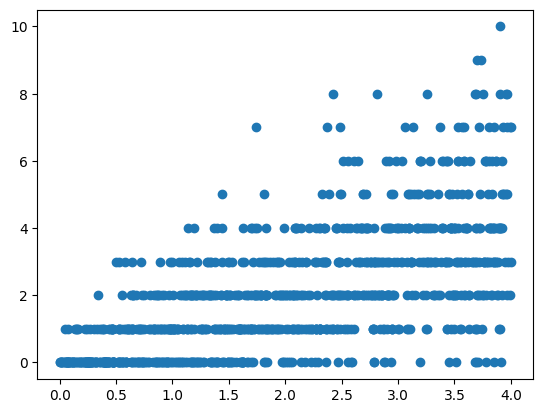

In [ ]:
n = 1000
np.random.seed(SEED)
X = np.random.uniform(low=0,high=4,size=n).reshape(-1,1)
y = np.random.poisson(lam=X.ravel(),size=n)
plt.scatter(X,y)
plt.show()

In [ ]:
kf = RepeatedKFold(n_splits= 5,n_repeats=20, random_state=SEED)
criterion = "poisson"
models = {  
                "baseline": BaseLineTree(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True),
                "NU": NaiveUpdate(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,),
                "TR":TreeReevaluation(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True, delta=0.1),
                "SR":StabilityRegularization(criterion = criterion,min_samples_leaf=5, adaptive_complexity=True,lmbda=0.75),
                "ABU":AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True)
                
                #  "baseline": BaseLineTree(**params), 
                # "NU": StableTree0(**params),
                #  "TR":TreeReevaluation(criterion = criterion,**params, delta=0.1)
                #  #"SR":StableTree2(**params,lmda=0.5),
                #  "ABU":AbuTreeI(**params)
                }

preds  = {k :np.zeros((200,100)) for k in models.keys()}
stability = {k :[] for k in models.keys()}
performance = {k :[] for k in models.keys()}
for i,(train_index, test_index) in enumerate(kf.split(X)):
        X_12, y_12 = X[train_index],y[train_index]
        X_test,y_test = X[test_index],y[test_index]
        X_test = np.sort(X_test)
        X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
        for name, model in models.items():
                model.fit(X1,y1)
                pred1 = model.predict(X_test)
                model.update(X_12,y_12)
                pred2 = model.predict(X_test)
                preds[name][:,i] = np.log((pred2+1.1)/(pred1+1.1)) #np.std(np.log((pred2+EPSILON)/(pred1+EPSILON)))
                stability[name].append( np.std(np.log((pred2+1.1)/(pred1+1.1))))
                performance[name] = mean_poisson_deviance(y_test+0.001, pred2+0.001)

0.10523990108792917
0.03358028351841121
0.03358028351841121
0.0552381306445934
0.1351971669835862


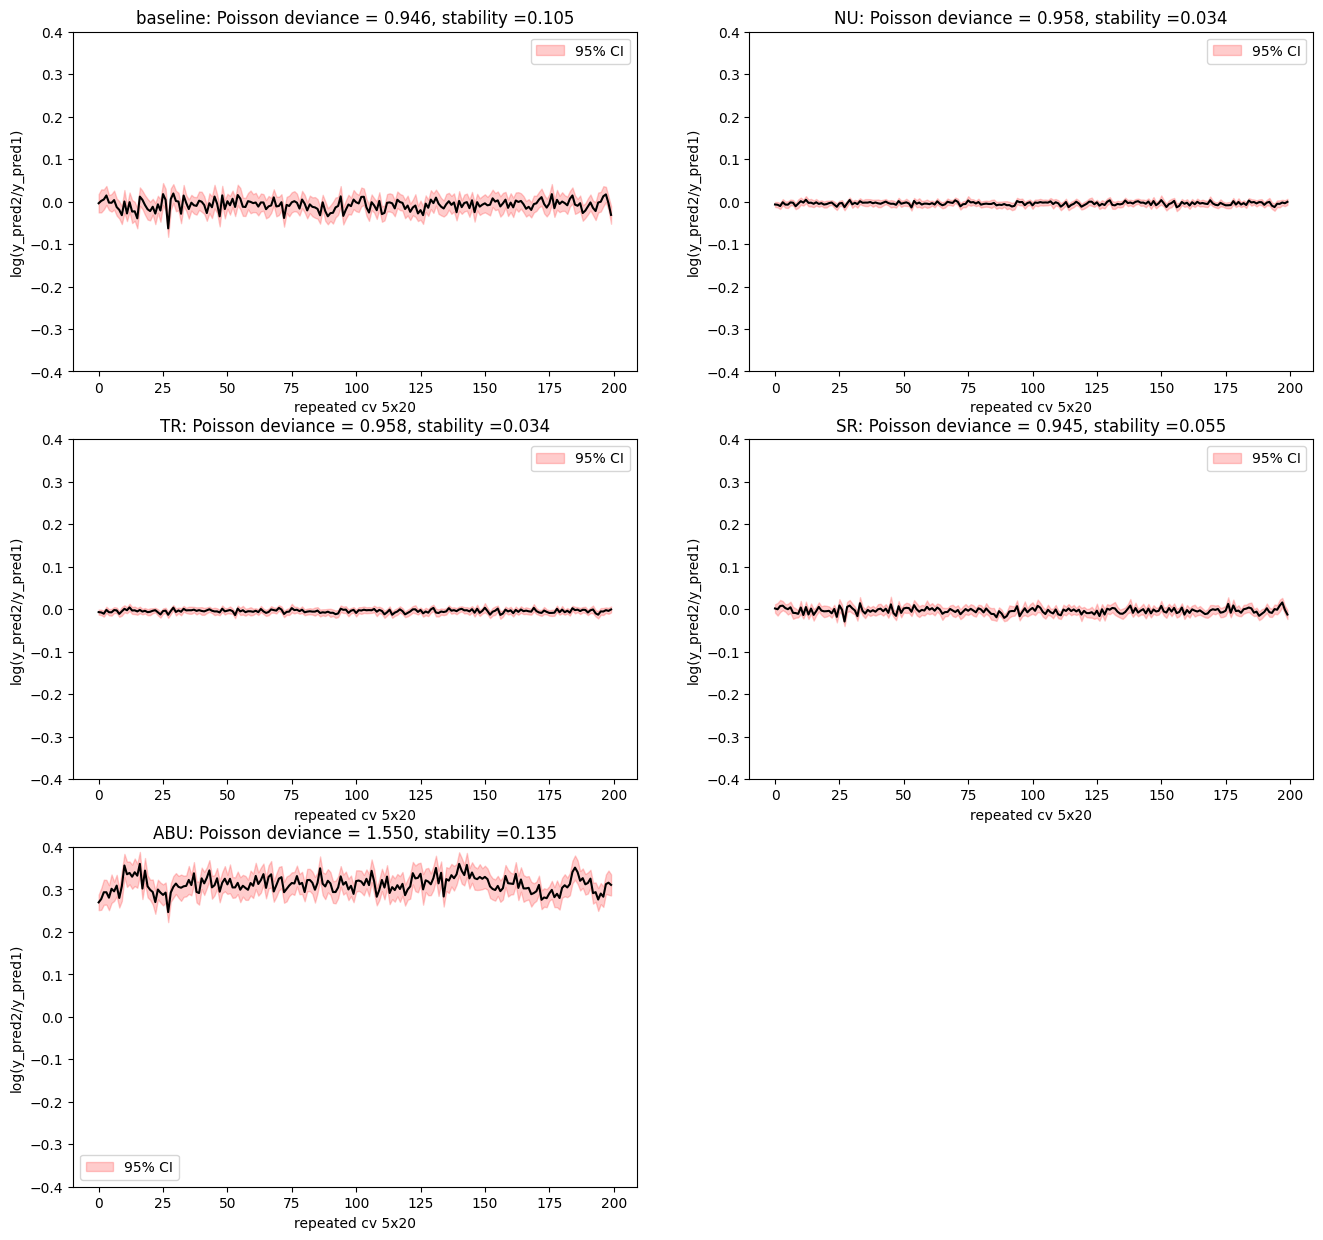

In [ ]:
fig = plt.figure(figsize=(16, 15))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(3,2,i+1)

    y_mean = np.mean(preds[name],axis=1)
    y_std = np.std(preds[name],axis=1)
    ci = 1.96 * y_std / np.sqrt(preds[name].shape[1])
    plt.plot(np.arange(0,preds[name].shape[0],1), y_mean, color = "black",)
    plt.fill_between(np.arange(0,preds[name].shape[0],1), y_mean-ci, y_mean+ci, alpha=0.2, label='95% CI', color = "red", interpolate=True)
    plt.ylim((-0.4,0.4))
    # Set the plot title and axis labels
    plt.xlabel('repeated cv 5x20')
    plt.ylabel('log(y_pred2/y_pred1)')
    plt.title(f'{name}: Poisson deviance = {np.mean(performance[name]):.3f}, stability ={np.mean(stability[name]):.3f}')
    plt.legend()
    print(np.mean(stability[name]))
    # Show the plot
plt.show()

In [ ]:
np.exp(preds["ABU"])

array([[1.2558839 , 1.25709512, 1.38560497, ..., 1.36230213, 1.2436951 ,
        1.32688312],
       [0.83794733, 1.20752467, 1.38560497, ..., 1.23760387, 1.37019856,
        1.21936165],
       [1.20225503, 1.25709512, 1.38560497, ..., 1.77583528, 1.2436951 ,
        1.21936165],
       ...,
       [1.34420069, 1.43109916, 1.38560497, ..., 1.23760387, 1.37019856,
        1.21936165],
       [1.34420069, 1.54123668, 1.50979172, ..., 1.55562006, 1.2436951 ,
        1.53403658],
       [1.2558839 , 1.54123668, 1.17400277, ..., 1.36230213, 1.2436951 ,
        1.73219311]])

In [ ]:
np.exp(preds["baseline"])

array([[0.98833139, 0.97499423, 1.11463377, ..., 1.06261754, 0.91996951,
        0.97589336],
       [1.32579338, 1.01994277, 1.11463377, ..., 1.14407715, 0.90833999,
        0.87231222],
       [0.95851137, 0.78345071, 1.11463377, ..., 0.96854834, 1.15679443,
        1.04538671],
       ...,
       [1.02411498, 1.02268954, 1.11463377, ..., 1.14407715, 1.1138546 ,
        1.04538671],
       [1.02411498, 1.08437104, 0.97399868, ..., 1.06940801, 0.91996951,
        1.05306476],
       [0.98833139, 1.08437104, 0.84201038, ..., 1.06261754, 0.91996951,
        0.96522074]])

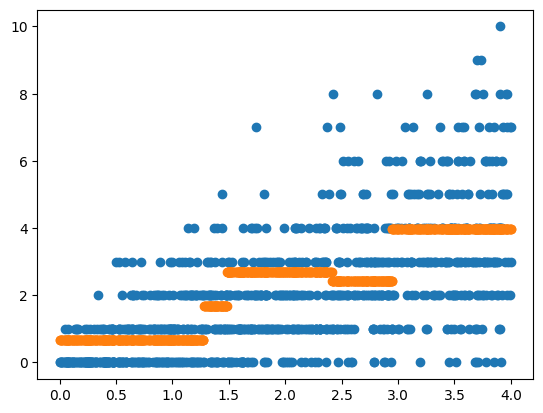

In [ ]:
plt.scatter(X,y)
plt.scatter(X,(tree.predict(X)))

In [ ]:
tree = AbuTreeI(criterion = criterion,min_samples_leaf=5,adaptive_complexity=True).fit(X,y)

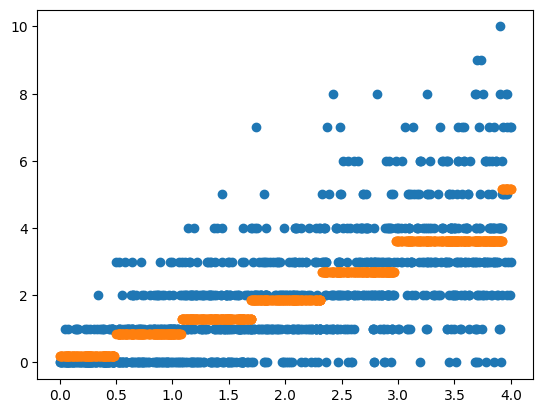

In [ ]:
plt.scatter(X,y)
plt.scatter(X,(tree.predict(X)))

In [ ]:
preds

{'baseline': array([[-0.01173722, -0.02532372,  0.10852589, ...,  0.06073525,
         -0.08341475, -0.02440196],
        [ 0.28201106,  0.01974652,  0.10852589, ...,  0.13459833,
         -0.09613653, -0.13660787],
        [-0.04237385, -0.24404712,  0.10852589, ..., -0.03195688,
          0.14565275,  0.04438688],
        ...,
        [ 0.02382881,  0.02243596,  0.10852589, ...,  0.13459833,
          0.10782661,  0.04438688],
        [ 0.02382881,  0.08100013, -0.02634533, ...,  0.06710523,
         -0.08341475,  0.05170473],
        [-0.01173722,  0.08100013, -0.17196294, ...,  0.06073525,
         -0.08341475, -0.03539846]]),
 'NU': array([[ 0.00734598, -0.04650256,  0.01359006, ..., -0.00461471,
         -0.00101678, -0.02440196],
        [-0.00573973,  0.01188091,  0.01359006, ...,  0.00631448,
         -0.01745566, -0.02852158],
        [-0.00973661, -0.04650256,  0.01359006, ..., -0.03195688,
         -0.00101678, -0.02852158],
        ...,
        [-0.00573973,  0.03228593,  